## Q-learning algorithm
- [강의 슬라이드](https://hunkim.github.io/ml/RL/rl03.pdf)
- [강의 동영상](https://www.youtube.com/watch?v=Vd-gmo-qO5E&feature=emb_imp_woyt)

- 라이브러리 
 - gym : OpenAI GYM에서 제공하고 있는 환경 중 FrozenLake-v3 환경을 생성

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
from gym.envs.registration import register

### q-table 
- env.observation_space.n, env.action_space.n : 상태공간과 행동공간의 행렬로 나타난다.
- FrozenLakeEnv : [ 16 x 4 ]
 - 상태(s) : S0(start), S1, S2, $...$, S15(Goal)
 - 행동(a) : LEFT, DOWN, RIGHT, UP

- q-value에 따른 q-value table 값 확인
 - q-learning을 통해 agent는 행동을 하면서 초기에 zero로 설정되어 있던 q-table의 값들을 reward값을 설정하며 update해 나간다. 결국 목적지로 갈 수 있는 루트를 알아내게된다.
<table>
	
	<tr><!-- 첫번째 줄 시작 -->
	    <td><img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbuE218%2FbtrAIf2Ndn1%2FDZBL1CdIfl2foHkpQhNCQK%2Fimg.png" width="400" height="250"/></td>
	    <td>
  L   D   R  U<br>
[[0. 1. 0. 0.] s0<br>
 [0. 0. 0. 0.] s1<br>
 [0. 0. 0. 0.] s2<br>
 [0. 0. 0. 0.] s3<br>
 [0. 1. 0. 0.] s4<br>
 [0. 0. 0. 0.] s5<br>
 [0. 0. 0. 0.] s6<br>
 [0. 0. 0. 0.] s7<br>
 [0. 0. 1. 0.] s8<br>
 [0. 1. 0. 0.] s9<br>
 [0. 0. 0. 0.] s10<br>
 [0. 0. 0. 0.] s11<br>
 [0. 0. 0. 0.] s12<br>
 [0. 0. 1. 0.] s13<br>
 [0. 0. 1. 0.] s14<br>
 [0. 0. 0. 0.]] s15<br>
 </td>
	</tr><!-- 첫번째 줄 끝 -->

    </table>






### rargmax 함수
- 상태 s 에서 Action(a)에 따른 네가지 q-value 중 가장 큰 것을 선택 
- q-value에 같은 값들이 있다면 랜덤하게 선택한 action을 반환


- 사례1  

```
state: 0
q_value[state, :]: [0. 0. 0. 0.]
max values: 0.0
indices: [0 1 2 3]
---->rargmax : indices[0 1 2 3] 중에 한가지를 랜덤하게 리턴
```


- 사례2

```
state: 8
q_value[state, :]: [0. 0. 1. 0.]
max values: 1.0
indices: [2]
---->rargmax : indices[2] 중에 한가지를 랜덤하게 리턴
```

In [ ]:
def rargmax(q_value, bPrint=False):    
    q_max = np.amax(q_value) # q_value array의 최댓값 반환
    indices = np.nonzero(q_value == q_max)[0] 
    if bPrint:
        print('q value :',q_value)
        print('max values:', q_max)
        print('indices:', indices) # max값이 있는 인덱스들
        print('--------------------------------')
    return random.choice(indices) # max값이 있는 인덱스이 복수개일때 하나를 선택

### 유틸리티 함수

In [ ]:
# 환경 등록
def get_env_register(env_id):    
    env_dict = gym.envs.registry.env_specs.copy()
 
    for env in env_dict:
        if env_id in env:
            print('Remove {} from registry'.format(env))
            del gym.envs.registry.env_specs[env]   

    register(
        id=env_id,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '4x4',
                'is_slippery': False}
    )
    env = gym.make(env_id)
    
    return env


# Q-table 시각화
def print_str_direct(q_value):
    cnt = 0
    while cnt < len(q_value):
        txt = ''
        for _ in range(4):
            q = ''.join([str(int(e)) for e in q_value[cnt]])
            if q == '1000':
                txt += STR_ACTION_UP
            elif q == '0100':
                txt += STR_ACTION_DOWN
            elif q == '0010':
                txt += STR_ACTION_RIGHT
            elif q == '0001':
                txt += STR_ACTION_LEFT
            else:
                txt += ' '
            txt += ' | '
            cnt += 1
        print(txt)    

def print_q_table(q_value):
    print('-'*50)
    print("Final Q-Table Values")
    print('-'*50)
    print('state | U   D   R   L')
    print(q_value)


환경 변수 

In [ ]:
NUM_EPISODES = 2000

IDX_ACTION_UP = 0
IDX_ACTION_DOWN = 1
IDX_ACTION_RIGHT = 2
IDX_ACTION_LEFT = 3

STR_ACTION_UP = 'U'
STR_ACTION_DOWN = 'D'
STR_ACTION_RIGHT = 'R'
STR_ACTION_LEFT = 'L'

ENV_ID = 'FrozenLake-v3'

### do_qlearning 함수

In [ ]:
# The Q-Table learning algorithm
def do_qlearning(env, num_episodes):
    q_value = np.zeros([env.observation_space.n, env.action_space.n])
    print('q_value shale:', q_value.shape)

    # create lists to contain total rewards and steps per episode
    rList = []
    cntList = []    #goal에 이르기까지 횟수 관리

    for i in range(num_episodes):
        state = env.reset() # state : 0,0부터 시작
        rAll = 0 # tatal reward
        done = False

        action_cnt = 0
        while not done:            
            action = rargmax(q_value[state, :]) #현재 state에서 최대 보상이 있는 action선택

            # Get new state and reward from environment
            new_state, reward, done, _ = env.step(action) # state변경

            # Update Q-Table with new knowledge using learning rate
            q_value[state, action] = reward + np.max(q_value[new_state, :]) #새로운 state에서 방금 행한 행동에 대한 정보 저장.

            rAll += reward
            state = new_state
            action_cnt +=1

        rList.append(rAll)
        cntList.append(action_cnt)

    return q_value, rList, cntList

q_value shale: (16, 4)
R | R | D |   | 
  |   | D |   | 
  |   | D |   | 
  |   | R |   | 
Success rate: 0.9465
Success average action : 6.0875


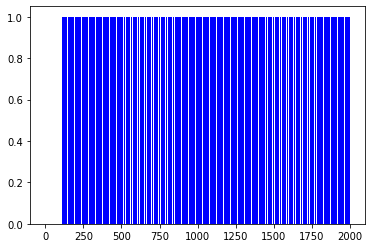

In [ ]:
random.seed(22)
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning(env, NUM_EPISODES)

#최종 route 출력
print_str_direct(q_value)
print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

그래프에서 보는것처럼 초반에는 성공하지 못하는 경우도 많다.

In [ ]:
print(list(map(int, rList[:10])))

[9, 4, 13, 4, 13, 26, 2, 2, 8, 9]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


goal에 도착하기 위해 시도하는 action의 count를 보면 초반에 여기저기 이동하면서 장애물에 부딛혀서 9회, 4회만에 종료된다.

하지만 경험이 쌓이면서 100회 이후부터 성공하는 경우가 생긴다. 
그래도 성공하기 위해 18, 19회정도 action을 취하는걸 보면 최단경로를 못찾은 것이다.

In [ ]:
print(cntList[100:110])
print(list(map(int, rList[100:110])))

[18, 2, 14, 3, 14, 11, 10, 3, 19, 2]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [ ]:
print(cntList[1000:1010])
print(list(map(int, rList[1000:1010])))

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


그래프에서 보는것처럼 150회의 경험이 쌓인후는 계속 6회만에 도착지점으로 가도록 학습되는 것을 알수 있다.




최종 경로를 가기위해 설정된 q-value도 함께 출력해보자.

In [ ]:
#최종 route 출력
print_str_direct(q_value)
print_q_table(q_value)

R | R | D |   | 
  |   | D |   | 
  |   | D |   | 
  |   | R |   | 
--------------------------------------------------
Final Q-Table Values
--------------------------------------------------
state | U   D   R   L
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


초반에는 goal에 도착하기위해 시도하는 횟수가 많다.

random seed를 다르게 설정하여 다른 시도도 하는지 확인해보자.

q_value shale: (16, 4)
D |   | D |   | 
D |   | D |   | 
R | D | D |   | 
  | R | R |   | 
Success rate: 0.8865
Success average action : 6.2685


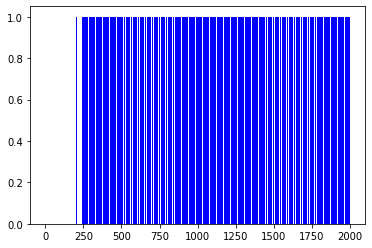

In [ ]:
random.seed(2022)
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning(env, NUM_EPISODES)

#최종 route 출력
print_str_direct(q_value)
print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

q_value shale: (16, 4)
D |   |   |   | 
D |   |   |   | 
R | D |   |   | 
  | R | R |   | 
Success rate: 0.815
Success average action : 6.348


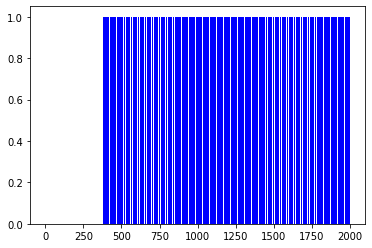

In [ ]:
random.seed(50)
env = get_env_register(ENV_ID)
q_value, rList, cntList = do_qlearning(env, NUM_EPISODES)

#최종 route 출력
print_str_direct(q_value)
print("Success rate: " + str(sum(rList) / NUM_EPISODES))
print("Success average action : " + str(sum(cntList) / NUM_EPISODES)) # 평균 액션 횟수
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

### Q-learning의 한계

- Exploit 만을 활용하는 문제
케이스에 따라(random하게 움직임을 선택) 성공률이 80%가까이 떨어지는 경우도 발생한다.  한번 발견한 길을 계속 유지하여 최단 거리로 갈수 있는 방법이 있지만 경험을 유지하는 알고리즘의 문제로 다른 더 좋은 방법을 찾지 못한다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FsVvPR%2FbtrAssBiz21%2F79W6i9Lz47N9I8ofqrMVz1%2Fimg.png" width="400" height="250"/>


- 다른 더 좋은 방법을 찾는법 ->  Exploration필요

